In [416]:
import cv2
import mediapipe as mp
import mediapipe.tasks.python.components.containers
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from itertools import product
import csv

In [417]:
pose_df = pd.read_csv('./data/pose.csv')
# pose_df = pd.read_csv('./data/pose2.csv')
pose_ts = pose_df.mean(axis=1)

In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import math


In [419]:

def calculate_length(p1 :tuple[int,int] , p2:tuple[int,int]) -> float:
    """
    두 점 사이의 거리를 계산합니다. (유클라디안 거리)
    :param p1: 첫 번째 점 (x, y)
    :param p2: 두 번째 점 (x, y)
    :return: 두 점 사이의 거리
    """
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def calculate_angle(p1:tuple[int,int], p2:tuple[int,int], p3:tuple[int,int]):
    """
    삼각형의 세 점 사이의 각도를 계산합니다.
    :param p1: 첫 번째 점 (x, y)
    :param p2: 두 번째 점 (x, y)
    :param p3: 세 번째 점 (x, y)
    :return: 삼각형의 세 점 사이의 각도 ∠p1p2p3
    """
    # 삼각형의 세 점 사이의 각도를 계산합니다.
    a = calculate_length(p1, p2)
    b = calculate_length(p2, p3)
    c = calculate_length(p3, p1)
    # 코사인 법칙을 사용하여 각도를 계산합니다.
    # ∠abc = arccos((a² + b² - c²) / 2ab)
    return math.degrees(math.acos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b)))

In [420]:
def remove_outliers_iqr(data, k=1.5):
    """
    IQR을 사용하여 이상치를 제거합니다.
    :param data: 시계열 데이터를 포함한 1차원 배열
    :param k: 이상치 판단 기준 (기본값: 1.5)
    :return: 이상치가 제거된 1차원 배열
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

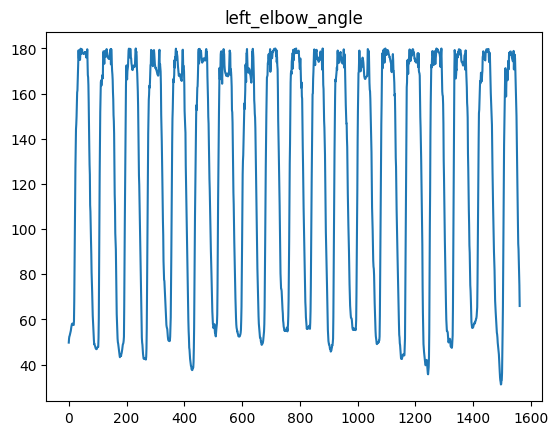

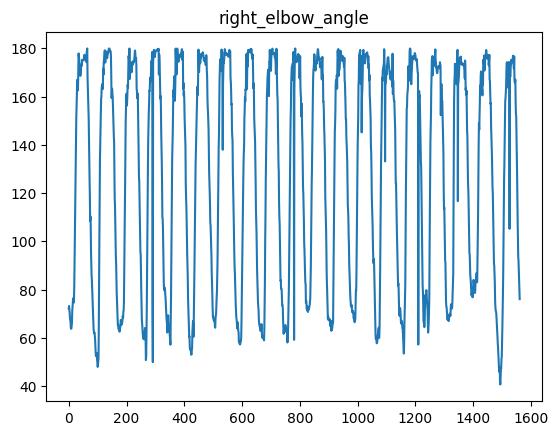

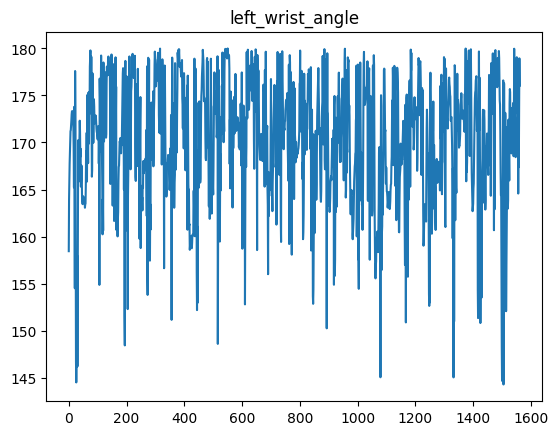

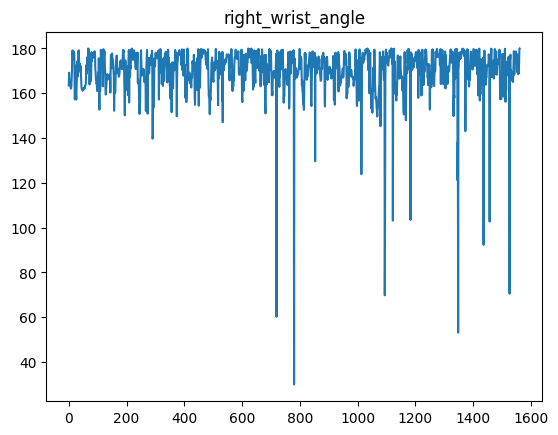

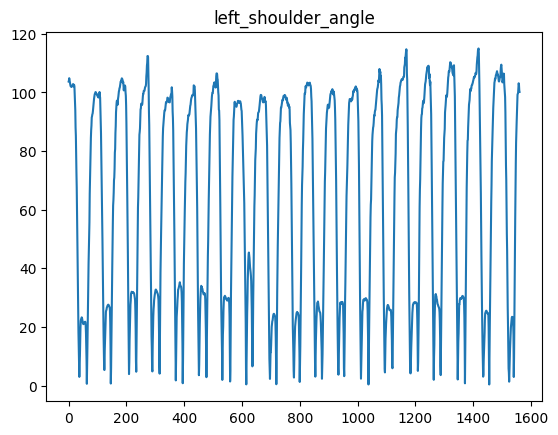

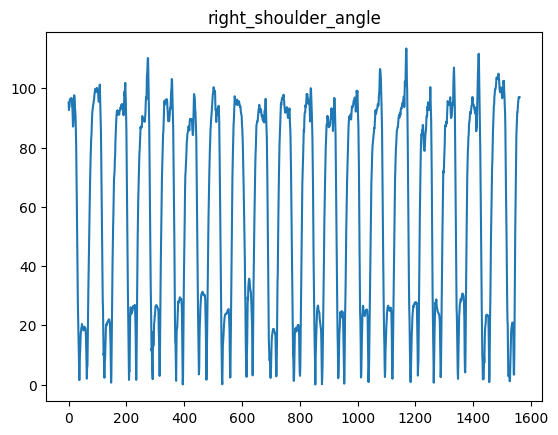

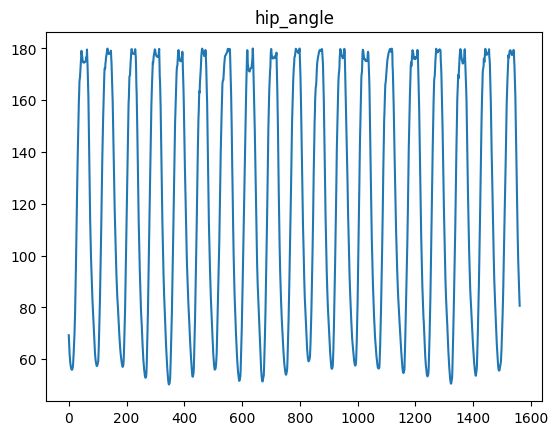

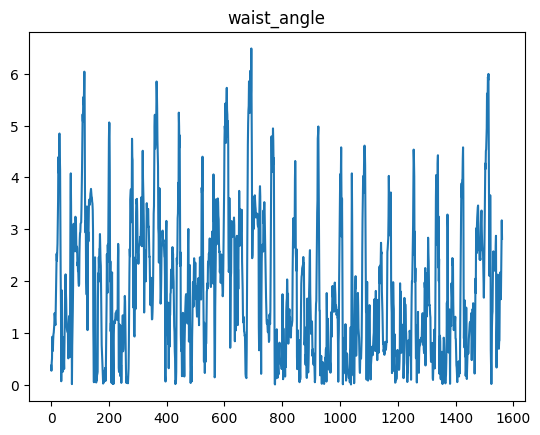

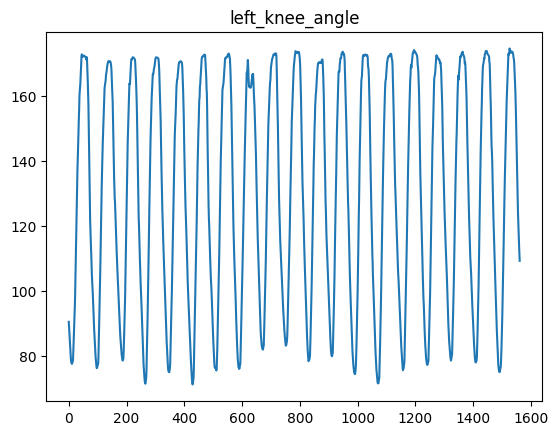

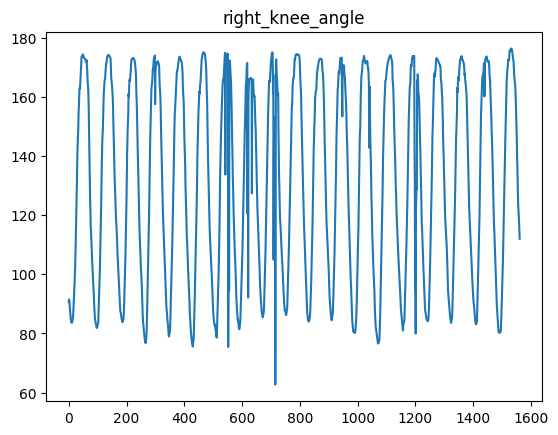

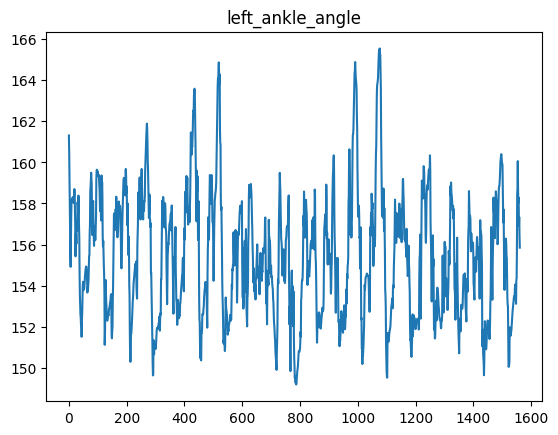

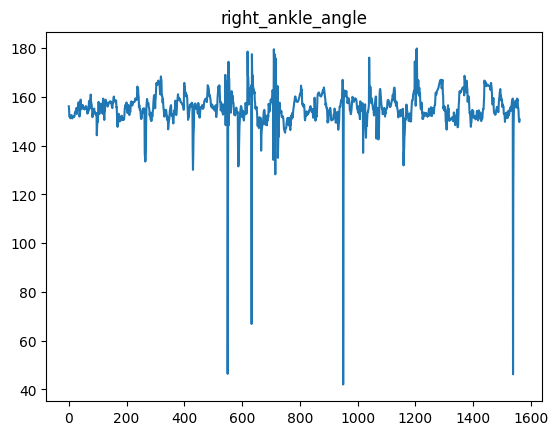

In [421]:
# 시각화
for column_name in pose_df.columns:
    plt.plot(pose_df[column_name])
    plt.title(column_name)
    plt.show()





In [422]:
# # 왼쪽 팔 각도 데이터 생성
# pose_df['elbow_angle_left'] = pose_df.apply(lambda row: calculate_angle((row['left_shoulder_x'], row['left_shoulder_y']),(row['left_elbow_x'], row['left_elbow_y']),(row['left_wrist_x'], row['left_wrist_y'])), axis=1)
# # 오른쪽 팔 각도 데이터 생성
# pose_df['elbow_angle_right'] = pose_df.apply(lambda row: calculate_angle((row['right_shoulder_x'], row['right_shoulder_y']),(row['right_elbow_x'], row['right_elbow_y']),(row['right_wrist_x'], row['right_wrist_y'])), axis=1)
# # 왼쪽 하체 각도 데이터 생성
# pose_df['knee_angle_left'] = pose_df.apply(lambda row: calculate_angle((row['left_hip_x'], row['left_hip_y']),(row['left_knee_x'], row['left_knee_y']),(row['left_ankle_x'], row['left_ankle_y'])), axis=1)
# # 오른쪽 하체 각도 데이터 생성
# pose_df['knee_angle_right'] = pose_df.apply(lambda row: calculate_angle((row['right_hip_x'], row['right_hip_y']),(row['right_knee_x'], row['right_knee_y']),(row['right_ankle_x'], row['right_ankle_y'])), axis=1)

In [423]:
import numpy as np
from scipy.signal import periodogram

fs = 30  # 영상의 프레임 속도(FPS). 비디오에 따라 조정해야 할 수 있습니다.
threshold = 1500  # 주기성이 있는 것으로 판단할 임계값. 이 값에 따라 결과가 달라질 수 있습니다.

# 주기성을 판단하는 함수
def find_dominant_period(data):
    # periodogram: 주파수와 주파수에 해당하는 파워를 계산합니다.(파워: 특정 주파수의 세기)
    freqs, power = periodogram(data, fs = 0.5)
    dominant_freq = freqs[np.argmax(power)]
    dominant_period = 1 / dominant_freq
    # power를 제곱근으로 변환합니다.
    power = np.sqrt(power)
    return dominant_period, power

landmark_columns =  pose_df.columns  # 랜드마크 x 좌표 열 이름

periodic_landmarks = []
power_df = pd.DataFrame(columns=['landmark', 'period', 'power'])

for column_name in landmark_columns:
    data = pose_df[column_name].values
    period, power = find_dominant_period(data)
    print(f"{column_name}: {period} frames power:{power.min(),power.max()}")
    # 데이터 프레임 원소 추가
    power_df = power_df.append({'landmark': column_name, 'period': period, 'power': power.max()}, ignore_index=True)
threshold = power_df['power'].mean() + power_df['power'].std() * 1/3
power_df = power_df[power_df['power'] > threshold]
print(power_df)

# print(power_df.std())
# print("Periodic landmarks:")
# for column_name, period, power in periodic_landmarks:
#     print(f"{column_name}: {period} frames power:{power.min(),power.max()}")


left_elbow_angle: 164.42105263157896 frames power:(3.7934425389744806e-13, 2549.070722511009)
right_elbow_angle: 164.42105263157896 frames power:(8.49202284194019e-14, 2210.603219343191)
left_wrist_angle: 164.42105263157896 frames power:(5.2884453626453886e-14, 114.4043793721607)
right_wrist_angle: 183.76470588235293 frames power:(4.235841333734239e-13, 72.02034344733816)
left_shoulder_angle: 164.42105263157896 frames power:(5.194372055713716e-13, 1723.1707376611298)
right_shoulder_angle: 164.42105263157896 frames power:(1.8890937040603479e-13, 1675.3538211542984)
hip_angle: 164.42105263157896 frames power:(1.06531663795597e-13, 2438.364195202496)
waist_angle: 3124.0 frames power:(3.9726903265064516e-15, 22.119616671615447)
left_knee_angle: 164.42105263157896 frames power:(9.11239816332744e-13, 1812.9635696739952)
right_knee_angle: 164.42105263157896 frames power:(1.062774116147006e-13, 1690.4440738283317)
left_ankle_angle: 164.42105263157896 frames power:(4.2409263773521673e-13, 108.0

/var/folders/kg/32fsv3cx71dc36x864rf22ym0000gn/T/ipykernel_36492/2286302831.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_df = power_df.append({'landmark': column_name, 'period': period, 'power': power.max()}, ignore_index=True)
/var/folders/kg/32fsv3cx71dc36x864rf22ym0000gn/T/ipykernel_36492/2286302831.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_df = power_df.append({'landmark': column_name, 'period': period, 'power': power.max()}, ignore_index=True)
/var/folders/kg/32fsv3cx71dc36x864rf22ym0000gn/T/ipykernel_36492/2286302831.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_df = power_df.append({'landmark': column_name, 'period': period, 'power': power.max()}, ignore_index=True)
/var/fo

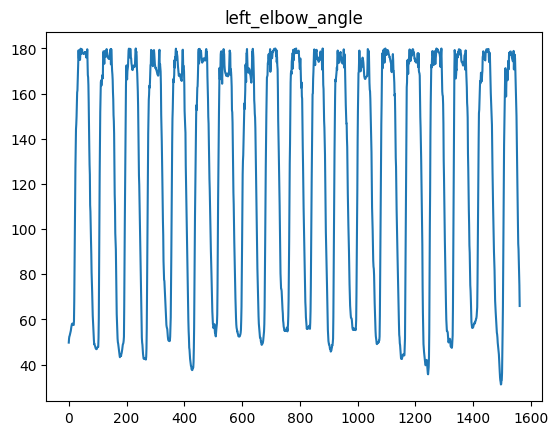

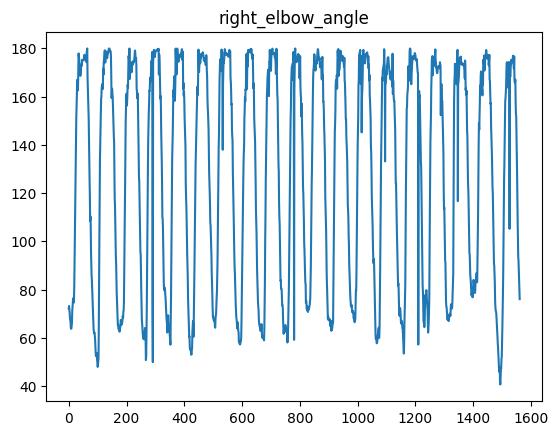

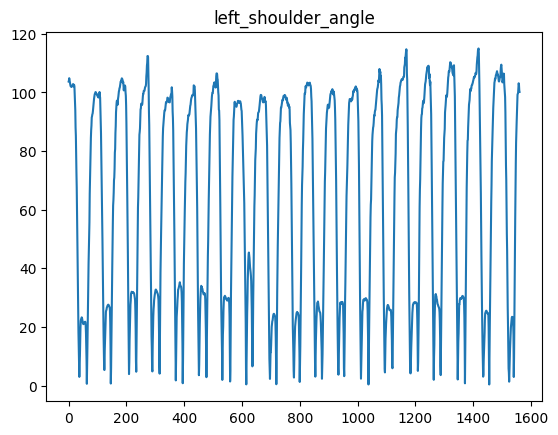

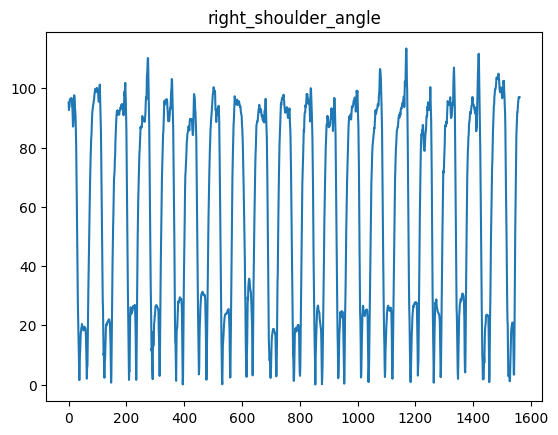

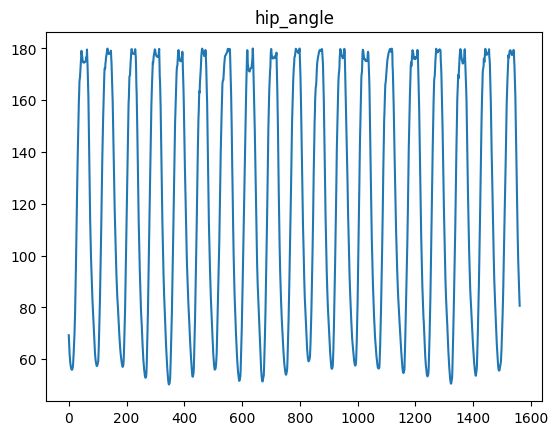

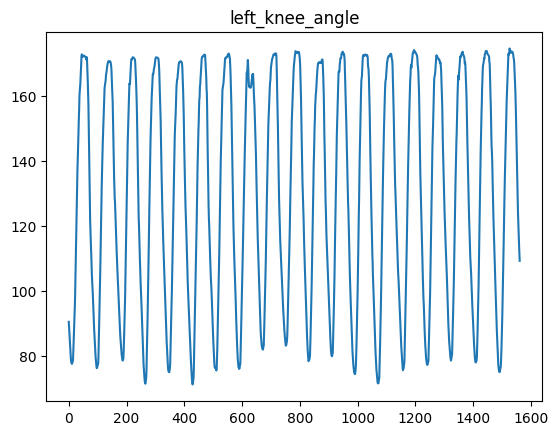

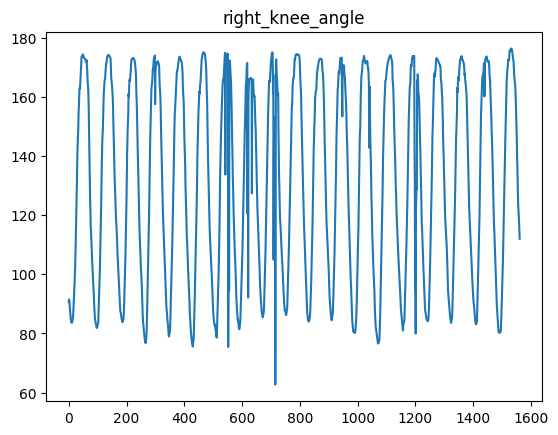

In [424]:
# power_df 시각화
for column_name in power_df['landmark']:
    plt.plot(pose_df[column_name])
    plt.title(column_name)
    plt.show()
    

In [428]:
# 각주기의 Range 구하기
# 주기성이 있는 랜드마크의 주기를 기준으로 데이터를 분할합니다.
# 분할된 데이터의 범위를 구합니다.
periodic_landmark_ranges = []
for column_name, period in power_df[['landmark', 'period']].values:
    # print(period)
    landmark_range = np.array([])
    for i in range(0, len(pose_df), int(period)):
        landmark_range = np.append(landmark_range,[pose_df[column_name][i:i + int(period)].values.max(),pose_df[column_name][i:i + int(period)].values.min()])
    landmark_range = landmark_range.reshape(-1,2)
    landmark_range_mean = (int(landmark_range[:,0].mean()), int(landmark_range[:,1].mean()))
    periodic_landmark_ranges.append((column_name, landmark_range_mean))
# 확인
for column_name, landmark_range_mean in periodic_landmark_ranges:
    print(f"{column_name}: {landmark_range_mean}")
# print(periodic_landmark_ranges,sep="\n")
# 각 데이터별 최소값, 최대값 평균 구하기


left_elbow_angle: (179, 43)
right_elbow_angle: (179, 54)
left_shoulder_angle: (107, 1)
right_shoulder_angle: (104, 0)
hip_angle: (179, 53)
left_knee_angle: (173, 75)
right_knee_angle: (174, 77)


In [ ]:
periodic_landmark_ranges.to_csv('periodic_landmark_ranges.csv', index=False)